In [1]:
!pip install libauc medmnist tensorboardX pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.4 MB/s eta 0:00:00


In [2]:
# Import required libraries
from tqdm import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from libauc.losses import AUCMLoss
from libauc.losses import AUCM_MultiLabel
from libauc.optimizers import PESG
from libauc.losses import APLoss
from libauc.losses.auc import pAUCLoss
from libauc.models import resnet18 as ResNet18
from libauc.optimizers import SOAP, SOPA
import torchvision.transforms as transforms
from libauc.sampler import DualSampler
from torch.utils.data import Dataset
import medmnist
from medmnist import INFO, Evaluator
from torch.utils.data import random_split
from libauc.metrics import auc_roc_score
from sklearn.metrics import accuracy_score, roc_auc_score
from libauc.metrics import auc_prc_score
from libauc.metrics import pauc_roc_score
# from libauc.utils import auroc
import torchvision
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lightning').setLevel(0)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logging.disable(logging.CRITICAL)

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(123)

In [4]:
class ResNet18WithDropout(nn.Module):
    def __init__(self, num_classes=1000, dropout_prob=0.5, layer_size=1):
        super(ResNet18WithDropout, self).__init__()
        self.resnet18 = ResNet18(pretrained=False)
        self.resnet18.conv1 = nn.Conv2d(layer_size, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet18.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
        
        # add dropout after certain layers
        self.resnet18.layer2.add_module('dropout', self.dropout)
        self.resnet18.layer3.add_module('dropout', self.dropout)
        self.resnet18.layer4.add_module('dropout', self.dropout)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [75]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=25, mode='train', data_aug_flag=False):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.data_aug_flag = data_aug_flag
        self.transform_aug_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              # transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(30),
                              # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                              # transforms.Resize((image_size, image_size)),
                              transforms.Normalize(mean=[.5], std=[.5])
                              ])
        self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              # transforms.Resize((64, 64)),
                              # transforms.Resize((image_size, image_size)),
                              transforms.Normalize(mean=[.5], std=[.5])
                              ])
        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                            #  transforms.Resize((64, 64)),
                            #  transforms.Resize((image_size, image_size)),
                             transforms.Normalize(mean=[.5], std=[.5])
                              ])


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        if self.mode == 'train':
           if self.data_aug_flag:
              image = self.transform_aug_train(image)
           else:
              image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target 

# Test Data
def test(model, data_flag, BATCH_SIZE):
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])
    test_dataset = DataClass(split='test', download=True)
    test_data = test_dataset.imgs 
    if data_flag != 'chestmnist':
        test_labels = test_dataset.labels[:, 0] 
        test_labels[test_labels != 0] = 99
        test_labels[test_labels == 0] = 1
        test_labels[test_labels == 99] = 0
    else:
        test_labels = test_dataset.labels

    # test_data = test_data/255.0 
    testSet = ImageDataset(test_data, test_labels, mode='test')
    test_loader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model.eval()
    best_val_auc = 0
    train_pred_list = []
    train_true_list = []
    with torch.no_grad():
        for index, inputs, targets in test_loader:
            inputs  = inputs.cuda()
            outputs = model(inputs)
            train_pred_list.append(outputs.cpu().detach().numpy())
            train_true_list.append(targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = np.mean(auc_roc_score(train_true, train_pred))
        train_pauc = np.mean(auc_prc_score(train_true, train_pred))
        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(train_pred)
        if best_val_auc < train_auc:
            best_val_auc = train_auc
        print('AUC for test is: ' + str(train_auc) + ' and PRC score is: ' + str(train_pauc)) 
        print('%s  auc: %s  acc:%s' % ('test', *metrics))
    return None
# Load and pre-process data
def load_train_test_data(data_flag, NUM_EPOCHS=100, imratio=0.25, dropout=0, data_aug_flag=False, early_stop_flag=False, lr=0.1, BATCH_SIZE=128, momentum=0.9, optimizer='pesg', weight_decay=0.0, epoch_decay=0.0, decay_factor=0, margin=1.0, decay_epochs=[50, 75]):
    download = True

    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # preprocessing
    # Load the Data
    train_dataset = DataClass(split='train', download=download)
    val_dataset = DataClass(split='val', download=download)

    train_data = train_dataset.imgs 
    if data_flag != 'chestmnist':
        train_labels = train_dataset.labels[:, 0] 
        train_labels[train_labels != 0] = 99
        train_labels[train_labels == 0] = 1
        train_labels[train_labels == 99] = 0
    else: 
        train_labels = train_dataset.labels
    # train_data = train_data/255.0
    val_data = val_dataset.imgs 
    if data_flag != 'chestmnist':
        val_labels = val_dataset.labels[:, 0] 
        val_labels[val_labels != 0] = 99
        val_labels[val_labels == 0] = 1
        val_labels[val_labels == 99] = 0
    else:
        val_labels = val_dataset.labels
 
    trainSet = ImageDataset(train_data, train_labels, mode='train', data_aug_flag=data_aug_flag)
    valSet = ImageDataset(val_data, val_labels, mode='test', data_aug_flag=data_aug_flag)
    trainSet_at_eval = ImageDataset(train_data, train_labels, mode='test', data_aug_flag=data_aug_flag)

    if data_flag!='chestmnist' and imratio > 0: 
        sampler = DualSampler(trainSet, batch_size=BATCH_SIZE, sampling_rate=imratio)
        train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
    else:
         train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, num_workers=2)
    

    val_loader = data.DataLoader(dataset=valSet, batch_size=2*BATCH_SIZE, shuffle=True)
    train_loader_at_eval = torch.utils.data.DataLoader(trainSet_at_eval, batch_size=2*BATCH_SIZE, shuffle=False)

    model = ResNet18(pretrained=False)
    # from torchvision.models import resnet18
    if data_flag == 'chestmnist':
        model =  ResNet18(pretrained=False, num_classes=n_classes)

    if n_channels == 1 and train_data.ndim == 3:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif train_data.ndim > 3:
        model.conv1 = nn.Conv2d(train_data.shape[1], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    if dropout > 0:
        model = ResNet18WithDropout(num_classes=n_classes, dropout_prob=dropout, layer_size=train_data.shape[1])
    model = model.cuda()
    
    loss_fn = AUCMLoss(imratio=imratio, margin=margin)

    if data_flag == 'chestmnist':
        loss_fn = AUCM_MultiLabel(num_classes=n_classes, imratio=imratio, margin=margin)
    
    if optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'pesg':
        optimizer = PESG(model, loss_fn=loss_fn, lr=lr, momentum=momentum, margin=margin, epoch_decay=epoch_decay, weight_decay=weight_decay)
    
    # Train Model
    best_val_auc = 0
    train_list, val_list = [], []
    # Define the early stopping criteria
    patience = 15 # Number of epochs to wait before stopping
    min_delta = 0.001 # Minimum change in validation loss to be considered as improvement
    best_loss = float('inf') # Initialize the best loss as infinity
    wait = 0 # Counter for the number of epochs since last improvement
    for epoch in range(NUM_EPOCHS):
        if epoch in decay_epochs and decay_factor > 0:
            optimizer.update_regularizer(decay_factor=decay_factor) # decrease learning rate by 10x & update regularizer
            # optimizer.update_lr(decay_factor=decay_factor) # decrease learning rate by 10x
        model.train()
        for index, inputs, targets in tqdm(train_loader, disable=True):
            inputs, targets  = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # if epoch % 10 == 0:
            # print(f'Epoch: {epoch} \tLoss: {loss.item():.6f}')
        model.eval()
        train_pred_list = []
        train_true_list = []
        val_pred_list = []
        val_true_list = []
        with torch.no_grad():
            for index, inputs, targets in train_loader_at_eval:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                train_pred_list.append(outputs.cpu().detach().numpy())
                train_true_list.append(targets.numpy())
            train_true = np.concatenate(train_true_list)
            train_pred = np.concatenate(train_pred_list)
            train_auc = np.mean(auc_roc_score(train_true, train_pred))
            train_list.append(train_auc)
            for index, inputs, targets in val_loader:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                val_pred_list.append(outputs.cpu().detach().numpy())
                val_true_list.append(targets.numpy())
            val_true = np.concatenate(val_true_list)
            val_pred = np.concatenate(val_pred_list)
            # val_auc = auc_roc_score(val_true, val_pred)
            val_auc = np.mean(auc_roc_score(val_true, val_pred))
            val_list.append(val_auc)
            val_loss = val_auc/len(val_loader)
            if best_val_auc < val_auc:
                best_val_auc = val_auc
        model.train()

        # Check if the validation loss has improved
        if early_stop_flag:
            delta_loss = abs(val_loss - best_loss)
            if delta_loss < min_delta:
                wait += 1
                if wait >= patience:
                    print("Validation loss stopped improving. Early stopping at epoch " + str(epoch))
                    break
            else:
                wait = 0
                best_loss = val_loss
 
    # print results
    print('AUC for train_eval is: ' + str(train_auc) + ' and val AUC is: ' + str(val_auc) + ' and best AUC is: ' + str(best_val_auc)) 

    return model, train_list, val_list

In [73]:
class ImageDataset_PRC(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=25, mode='train', data_aug_flag=False):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.data_aug_flag = data_aug_flag
        self.transform_aug_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              # transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(30),
                              # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                              # transforms.Resize((image_size, image_size)),
                              transforms.Normalize(mean=[.5], std=[.5])
                              ])
        self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              # transforms.Resize((image_size, image_size)),
                              transforms.Normalize(mean=[.5], std=[.5])
                              ])
        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                            #  transforms.Resize((image_size, image_size)),
                             transforms.Normalize(mean=[.5], std=[.5])
                              ])
          # for loss function
        self.pos_indices = np.flatnonzero(targets==1)
        self.pos_index_map = {}
        for i, idx in enumerate(self.pos_indices):
            self.pos_index_map[idx] = i


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        # image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
           idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
           if self.data_aug_flag:
              image = self.transform_aug_train(image)
           else:
              image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target 

# Test Data
def test_prc(model, data_flag, BATCH_SIZE):
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])
    test_dataset = DataClass(split='test', download=True)
    test_data = test_dataset.imgs 
    if data_flag != 'chestmnist':
        test_labels = test_dataset.labels[:, 0] 
        test_labels[test_labels != 0] = 99
        test_labels[test_labels == 0] = 1
        test_labels[test_labels == 99] = 0
    else:
        test_labels = test_dataset.labels

    # test_data = test_data/255.0 
    testSet = ImageDataset_PRC(test_data, test_labels, mode='test')
    test_loader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model.eval()
    best_val_auc = 0
    train_pred_list = []
    train_true_list = []
    with torch.no_grad():
        for index, inputs, targets in test_loader:
            inputs  = inputs.cuda()
            outputs = model(inputs)
            train_pred_list.append(outputs.cpu().detach().numpy())
            train_true_list.append(targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = np.mean(auc_prc_score(train_true, train_pred))
        train_pauc = pauc_roc_score(train_true, train_pred, max_fpr=0.3)
        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(train_pred)

        if best_val_auc < train_auc:
            best_val_auc = train_auc
        print('AUC for test is: ' + str(train_auc) + ' and Partial AUC is: ' + str(train_pauc)) 
        print('%s  auc: %s  acc:%s' % ('test', *metrics))
    return None
# Load and pre-process data
def load_train_test_data_prc(data_flag, NUM_EPOCHS=100, imratio=0.25, dropout=0.5, data_aug_flag=False, lr=0.1, BATCH_SIZE=128, momentum=0.9, optimizer='pesg', weight_decay=0.0, epoch_decay=0.0, decay_factor=10, margin=1.0, decay_epochs=[50, 75]):
    download = True

    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # preprocessing
    # Load the Data
    train_dataset = DataClass(split='train', download=download)
    val_dataset = DataClass(split='val', download=download)

    train_data = train_dataset.imgs 
    train_labels = train_dataset.labels[:, 0] 
    train_labels[train_labels != 0] = 99
    train_labels[train_labels == 0] = 1
    train_labels[train_labels == 99] = 0
    # train_data = train_data/255.0
    val_data = val_dataset.imgs 
    val_labels = val_dataset.labels[:, 0] 
    val_labels[val_labels != 0] = 99
    val_labels[val_labels == 0] = 1
    val_labels[val_labels == 99] = 0
 
    trainSet = ImageDataset_PRC(train_data, train_labels, mode='train', data_aug_flag=data_aug_flag)
    valSet = ImageDataset_PRC(val_data, val_labels, mode='test', data_aug_flag=data_aug_flag)
    trainSet_at_eval = ImageDataset_PRC(train_data, train_labels, mode='test', data_aug_flag=data_aug_flag)

    if imratio > 0 and data_flag != 'chestmnist': 
        sampler = DualSampler(trainSet, batch_size=BATCH_SIZE, sampling_rate=imratio)
        train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
    else:
         train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, num_workers=2)
    

    val_loader = data.DataLoader(dataset=valSet, batch_size=BATCH_SIZE, shuffle=True)
    train_loader_at_eval = torch.utils.data.DataLoader(trainSet_at_eval, batch_size=BATCH_SIZE, shuffle=False)

    model = ResNet18(pretrained=False, last_activation=None)

    # model = torchvision.models.resnet18(pretrained=False, num_classes=n_classes, progress=False)
    # model = ResNet18WithDropout(num_classes=n_classes, dropout_prob=dropout)
    # model = ModifiedResNet18(num_classes=n_classes, dropout_prob=0.5)
    if n_channels == 1 and train_data.ndim == 3:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif train_data.ndim > 3:
        model.conv1 = nn.Conv2d(train_data.shape[1], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = model.cuda()
    
    loss_fn = APLoss(pos_len=sampler.pos_len, margin=margin, gamma=0.1)
    
    if optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'pesg':
        optimizer = PESG(model, loss_fn=loss_fn, lr=lr, momentum=momentum, margin=margin, epoch_decay=epoch_decay, weight_decay=weight_decay)
    optimizer = SOAP(model.parameters(), lr=lr, mode='adam', weight_decay=weight_decay)
    
    # Train Model
    best_val_auc = 0
    train_list, val_list = [], []
    for epoch in range(NUM_EPOCHS):
        if epoch in decay_epochs and decay_factor > 0:
            optimizer.update_lr(decay_factor=decay_factor) # decrease learning rate by 10x & update regularizer
        model.train()
        for index, inputs, targets in tqdm(train_loader, disable=True):
            inputs, targets  = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = loss_fn(outputs, targets, index)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # if epoch % 50 == 0:
            # print(f'Epoch: {epoch} \tLoss: {loss.item():.6f}')
        model.eval()
        train_pred_list = []
        train_true_list = []
        val_pred_list = []
        val_true_list = []
        with torch.no_grad():
            for index, inputs, targets in train_loader_at_eval:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                train_pred_list.append(outputs.cpu().detach().numpy())
                train_true_list.append(targets.numpy())
            train_true = np.concatenate(train_true_list)
            train_pred = np.concatenate(train_pred_list)
            train_auc = np.mean(auc_prc_score(train_true, train_pred))
            train_list.append(train_auc)
            for index, inputs, targets in val_loader:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                val_pred_list.append(outputs.cpu().detach().numpy())
                val_true_list.append(targets.numpy())
            val_true = np.concatenate(val_true_list)
            val_pred = np.concatenate(val_pred_list)
            val_auc = auc_roc_score(train_true, train_pred)
            val_list.append(val_auc)
            if best_val_auc < val_auc:
                best_val_auc = val_auc
        model.train()
 
    # print results
    print('AUC for train_eval is: ' + str(train_auc) + ' and val AUC is: ' + str(val_auc) + ' and best AUC is: ' + str(best_val_auc)) 

    return model, train_list, val_list

In [18]:
# Load and pre-process data
def load_train_test_data_paurc(data_flag, NUM_EPOCHS=100, imratio=0.25, dropout=0.5, data_aug_flag=False, lr=0.1, BATCH_SIZE=128, momentum=0.9, optimizer='pesg', weight_decay=0.0, epoch_decay=0.0, decay_factor=10, margin=1.0, decay_epochs=[50, 75]):
    download = True

    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # preprocessing
    # Load the Data
    train_dataset = DataClass(split='train', download=download)
    val_dataset = DataClass(split='val', download=download)

    train_data = train_dataset.imgs 
    train_labels = train_dataset.labels[:, 0] 
    train_labels[train_labels != 0] = 99
    train_labels[train_labels == 0] = 1
    train_labels[train_labels == 99] = 0
    # train_data = train_data/255.0
    val_data = val_dataset.imgs 
    val_labels = val_dataset.labels[:, 0] 
    val_labels[val_labels != 0] = 99
    val_labels[val_labels == 0] = 1
    val_labels[val_labels == 99] = 0
 
    trainSet = ImageDataset_PRC(train_data, train_labels, mode='train', data_aug_flag=data_aug_flag)
    valSet = ImageDataset_PRC(val_data, val_labels, mode='test', data_aug_flag=data_aug_flag)
    trainSet_at_eval = ImageDataset_PRC(train_data, train_labels, mode='test', data_aug_flag=data_aug_flag)

    if imratio > 0: 
        sampler = DualSampler(trainSet, batch_size=BATCH_SIZE, sampling_rate=imratio)
        train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
    else:
         train_loader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, num_workers=2)
    

    val_loader = data.DataLoader(dataset=valSet, batch_size=BATCH_SIZE, shuffle=True)
    train_loader_at_eval = torch.utils.data.DataLoader(trainSet_at_eval, batch_size=BATCH_SIZE, shuffle=False)

    model = ResNet18(pretrained=False, last_activation=None)

    # model = torchvision.models.resnet18(pretrained=False, num_classes=n_classes, progress=False)
    # model = ResNet18WithDropout(num_classes=n_classes, dropout_prob=dropout)
    # model = ModifiedResNet18(num_classes=n_classes, dropout_prob=0.5)
    if n_channels == 1 and train_data.ndim == 3:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif train_data.ndim > 3:
        model.conv1 = nn.Conv2d(train_data.shape[1], 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = model.cuda()
    
    loss_fn = pAUCLoss(pos_len=sampler.pos_len, backend='SOPA', margin=margin, beta=0.1)
    
    if optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'pesg':
        optimizer = PESG(model, loss_fn=loss_fn, lr=lr, momentum=momentum, margin=margin, epoch_decay=epoch_decay, weight_decay=weight_decay)
    optimizer = SOPA(model.parameters(), loss_fn=loss_fn.loss_fn, lr=lr, mode='adam', weight_decay=weight_decay, eta=1e1)
    
    # Train Model
    best_val_auc = 0
    train_list, val_list = [], []
    for epoch in range(NUM_EPOCHS):
        if epoch in decay_epochs and decay_factor > 0:
            optimizer.update_lr(decay_factor=decay_factor) # decrease learning rate by 10x & update regularizer
        model.train()
        for index, inputs, targets in tqdm(train_loader, disable=True):
            inputs, targets  = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = loss_fn(outputs, targets, index)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # if epoch % 50 == 0:
            # print(f'Epoch: {epoch} \tLoss: {loss.item():.6f}')
        model.eval()
        train_pred_list = []
        train_true_list = []
        val_pred_list = []
        val_true_list = []
        with torch.no_grad():
            for index, inputs, targets in train_loader_at_eval:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                train_pred_list.append(outputs.cpu().detach().numpy())
                train_true_list.append(targets.numpy())
            train_true = np.concatenate(train_true_list)
            train_pred = np.concatenate(train_pred_list)
            train_auc = np.mean(pauc_roc_score(train_true, train_pred, max_fpr=0.3))
            train_list.append(train_auc)
            for index, inputs, targets in val_loader:
                inputs  = inputs.cuda()
                outputs = model(inputs)
                val_pred_list.append(outputs.cpu().detach().numpy())
                val_true_list.append(targets.numpy())
            val_true = np.concatenate(val_true_list)
            val_pred = np.concatenate(val_pred_list)
            val_auc = pauc_roc_score(train_true, train_pred, max_fpr=0.3)
            val_list.append(val_auc)
            if best_val_auc < val_auc:
                best_val_auc = val_auc
        model.train()
 
    # print results
    print('AUC for train_eval is: ' + str(train_auc) + ' and val AUC is: ' + str(val_auc) + ' and best AUC is: ' + str(best_val_auc)) 

    return model, train_list, val_list

# Breast MNIST

In [ ]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['breastmnist']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

100%|██████████| 559580/559580 [00:00<00:00, 566155.38it/s]

Class Distribution: Counter({1: 399, 0: 147})
Class 1: 73.08%
Class 0: 26.92%


In [21]:
# Breast MNIST - Without Sampler, lr=0.1, batch=128
model = load_train_test_data('breastmnist', 100, 0)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.9197994987468672 and best AUC is: 0.9406850459482039


In [22]:
# Breast MNIST - With Sampler - lr=0.1, batch=128 - with/without not so much effect - Let's go with sampling
model = load_train_test_data('breastmnist', 100, 0.25)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.9398496240601504 and best AUC is: 0.9423558897243108


In [23]:
# Breast MNIST - With Sampler and Data Aug - lr=0.1, batch=128 - Data Aug not working
model = load_train_test_data('breastmnist', 100, 0.25, 0, True)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.44672906756687636 and val AUC is: 0.34001670843776105 and best AUC is: 0.5405179615705932


In [24]:
# Data Augmentation with sampler and epoch and weight decay - Not working
model = load_train_test_data('breastmnist', 100, 0.25, 0, True, False, 0.1, 128, 0.9, 'pesg', 0.0001, 0.003)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.4435578742775306 and val AUC is: 0.3483709273182958 and best AUC is: 0.758563074352548


In [ ]:
# Trying different batch sizes - lower batch sizes are doing good - lets go with 64
batch_sizes = [32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.1, batch_size)

==> Applying Batch Size: 32
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.5869759143621767 and best AUC is: 0.6592328278322925 and Mean AUC is: 0.5869759143621767
==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.6057091882247992 and best AUC is: 0.6208742194469224 and Mean AUC is: 0.6057091882247992
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.5718108831400535 and best AUC is: 0.5771632471008028 and Mean AUC is: 0.5718108831400535
==> Applying Batch Size: 256
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using do

In [ ]:
# Trying different Optimizers - PESG works
optimizers = ['sgd', 'adam', 'rmsprop', 'pesg']
for optimizer in optimizers:
    print('==> Applying Optimizer: ' + str(optimizer))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.1, 64, 0.9, optimizer)

==> Applying Optimizer: sgd
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.47603703135389497 and val AUC is: 0.5120428189116859 and best AUC is: 0.5539696699375557 and Mean AUC is: 0.5120428189116859
==> Applying Optimizer: adam
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.4347092220346785 and val AUC is: 0.6610169491525424 and best AUC is: 0.6770740410347904 and Mean AUC is: 0.6610169491525424
==> Applying Optimizer: rmsprop
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.5306292943242461 and val AUC is: 0.43978590544157 and best AUC is: 0.6030330062444246 and Mean AUC is: 0.43978590544157
==> Applying Optimizer: pesg
Using downloaded and verified 

In [ ]:
# Trying different learning rates - 0.001 is better
learning_rates = [0.1, 0.01, 0.001] 
for learning_rate in learning_rates:
    print('==> Applying Learning Rate: ' + str(learning_rate))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, learning_rate, 64, 0.9, 'pesg')

==> Applying Learning Rate: 0.1
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.9954307537551361 and val AUC is: 0.5593220338983051 and best AUC is: 0.5646743978590545 and Mean AUC is: 0.5593220338983051
==> Applying Learning Rate: 0.01
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.5432649420160571 and best AUC is: 0.552185548617306 and Mean AUC is: 0.5432649420160571
==> Applying Learning Rate: 0.001
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.6181980374665477 and best AUC is: 0.6369313113291704 and Mean AUC is: 0.6181980374665477


In [ ]:
# Control Overfitting - Adding weight decay - 1e-05 is better
weight_decays = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]
for weight_decay in weight_decays:
    print('==> Applying Weight Decay: ' + str(weight_decay))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.001, 64, 0.9, 'pesg', weight_decay)

==> Applying Weight Decay: 0.001
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.615521855486173 and best AUC is: 0.6181980374665477 and Mean AUC is: 0.615521855486173
==> Applying Weight Decay: 0.0001
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.9991304792593729 and val AUC is: 0.5414808206958073 and best AUC is: 0.6788581623550402 and Mean AUC is: 0.5414808206958073
==> Applying Weight Decay: 1e-05
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.6271186440677966 and best AUC is: 0.632471008028546 and Mean AUC is: 0.6271186440677966
==> Applying Weight Decay: 1e-06
Using downloaded and verified file: /root/.me

In [ ]:
# Control Overfitting - Adding epoch decay - 0.0001 is better
epoch_decays = [0.1, 0.01, 0.001, 0.0001]
for epoch_decay in epoch_decays:
    print('==> Applying Epoch Decay: ' + str(epoch_decay))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.001, 64, 0.9, 'pesg', 1e-05, epoch_decay)

==> Applying Epoch Decay: 0.1
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.5334522747546834 and best AUC is: 0.5557537912578054 and Mean AUC is: 0.5334522747546834
==> Applying Epoch Decay: 0.01
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.9996419620479772 and val AUC is: 0.5905441570026762 and best AUC is: 0.615521855486173 and Mean AUC is: 0.5905441570026762
==> Applying Epoch Decay: 0.001
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.9997613080319847 and val AUC is: 0.5066904549509367 and best AUC is: 0.5584299732381801 and Mean AUC is: 0.5066904549509367
==> Applying Epoch Decay: 0.0001
Using downloaded and verified file:

In [ ]:
# Trying different learning and decay rates - lr starts high and then gradually decreasing it for every 25 epochs - 0.001 with 100 is better
learning_rates = [0.1, 0.01, 0.001] 
decay_rates = [10, 100]
for learning_rate in learning_rates:
    for decay_rate in decay_rates:
        print('==> Applying Learning Rate: ' + str(learning_rate) + ' with decay: ' + str(decay_rate))
        model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, learning_rate, 64, 0.9, 'pesg', 1e-5, 1e-3, decay_rate)

==> Applying Learning Rate: 0.1 with decay: 10
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.01000 @ T=450!
Updating regularizer @ T=450!
Reducing learning rate to 0.00100 @ T=675!
Updating regularizer @ T=675!
AUC for train_eval is: 1.0 and val AUC is: 0.5744870651204281 and best AUC is: 0.5896520963425513 and Mean AUC is: 0.5744870651204281
==> Applying Learning Rate: 0.1 with decay: 100
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00100 @ T=450!
Updating regularizer @ T=450!
Reducing learning rate to 0.00001 @ T=675!
Updating regularizer @ T=675!
AUC for train_eval is: 1.0 and val AUC is: 0.568242640499554 and best AUC is: 0.5816235504014273 and Mean AUC is: 0.568242640499554
==> Applying Learning Rate: 0.01 with decay: 10
Using downloaded and verifi

In [ ]:
# Different margin rates - Not much effect
margins = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
for margin in margins:
    print('==> Applying Margin: ' + str(margin))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.01, 64, 0.9, 'pesg', 1e-3, 0.001, 100, margin)

==> Applying Margin: 0.1
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00010 @ T=450!
Updating regularizer @ T=450!
Reducing learning rate to 0.00000 @ T=675!
Updating regularizer @ T=675!
AUC for train_eval is: 0.9852351968356265 and val AUC is: 0.5263157894736842 and best AUC is: 0.5735950044603033 and Mean AUC is: 0.5263157894736842
==> Applying Margin: 0.3
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00010 @ T=450!
Updating regularizer @ T=450!
Reducing learning rate to 0.00000 @ T=675!
Updating regularizer @ T=675!
AUC for train_eval is: 1.0 and val AUC is: 0.5379125780553077 and best AUC is: 0.5477252453166814 and Mean AUC is: 0.5379125780553077
==> Applying Margin: 0.5
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using down

In [ ]:
# Final Trying different batch sizes - lower batch sizes are doing good - lets go with 64
batch_sizes = [32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.01, batch_size, 0.9, 'pesg', 1e-5, 1e-3, 100)

==> Applying Batch Size: 32
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00010 @ T=900!
Updating regularizer @ T=900!
Reducing learning rate to 0.00000 @ T=1350!
Updating regularizer @ T=1350!
AUC for train_eval is: 1.0 and val AUC is: 0.5414808206958073 and best AUC is: 0.5860838537020517 and Mean AUC is: 0.5414808206958073
==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00010 @ T=450!
Updating regularizer @ T=450!
Reducing learning rate to 0.00000 @ T=675!
Updating regularizer @ T=675!
AUC for train_eval is: 1.0 and val AUC is: 0.5932203389830508 and best AUC is: 0.647636039250669 and Mean AUC is: 0.5932203389830508
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using download

In [ ]:
# Early Stopping - Not working
model = load_train_test_data('breastmnist', 100, 0.25, 0, False, True, 0.1, 128, 0.9, 'pesg', 1e-5, 1e-3, 100)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for train_eval is: 0.9698395648986411 and val AUC is: 0.49866190900981266 and best AUC is: 0.5869759143621766 and Mean AUC is: 0.49866190900981266


In [ ]:
# Dropout
model = load_train_test_data('breastmnist', 100, 0.25, 0.2, False, False, 0.1, 128, 0.9, 'pesg', 0.0001, 0.003)

In [35]:
# Evaluate on Test Set - AUROC
model, train_log, val_log = load_train_test_data('breastmnist', 100, 0.25, 0, False, False, 0.1, 128, 0.9, 'pesg', 1e-5, 1e-3, 100)
# Save the model
torch.save(model.state_dict(), 'breast_mnist_model.pt')
print('==> Evaluating ...')
test(model, 'breastmnist', 256)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00100 @ T=200!
Updating regularizer @ T=200!
Reducing learning rate to 0.00001 @ T=300!
Updating regularizer @ T=300!
AUC for train_eval is: 1.0 and val AUC is: 0.9490392648287385 and best AUC is: 0.9490392648287385
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for test is: 0.8968253968253967 and PRC score is: 0.7612918823193209
test  auc: 0.10317460317460317  acc:0.14102564102564102


In [30]:
# Evaluate on Test Set - AUPRC
model, train_log_prc, val_log_prc = load_train_test_data_prc('breastmnist', 100, 0.25, 0, False, 0.01, 128, 0.9, '', 1e-2, 0.1, 100)
# Save the model
torch.save(model.state_dict(), 'breast_mnist_prc_model.pt')
print('==> Evaluating ...')
test_prc(model, 'breastmnist', 256)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Reducing learning rate to 0.00010 @ T=200!
Reducing learning rate to 0.00000 @ T=300!
AUC for train_eval is: 0.833494031125817 and val AUC is: 0.8730329224421598 and best AUC is: 0.8743116294136701
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for test is: 0.7237150078850779 and Partial AUC is: 0.8121938834013138
test  auc: 0.14995822890559732  acc:0.1346153846153846


In [31]:
# Evaluate on Test Set - PAURC
model, train_log_paurc, val_log_paurc = load_train_test_data_paurc('breastmnist', 100, 0.25, 0, False, 0.01, 128, 0.9, '', 1e-2, 1e-1, 100)
# Save the model
torch.save(model.state_dict(), 'breast_mnist_paurc_model.pt')
print('==> Evaluating ...')
test_prc(model, 'breastmnist', 256)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Backend loss: SOPA
Reducing lr to 0.00010 @ T=200!
Reducing lr to 0.00000 @ T=300!
AUC for train_eval is: 0.8034635742350408 and val AUC is: 0.8034635742350408 and best AUC is: 0.8045333421589187
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
AUC for test is: 0.7525368341558977 and Partial AUC is: 0.7939292676134782
test  auc: 0.15768588137009187  acc:0.23717948717948717


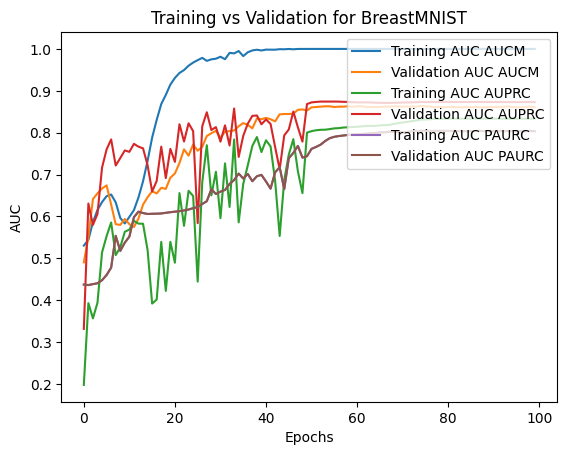

In [33]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for BreastMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('breast_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'breastmnist', 256)

==> Evaluating ...


100%|██████████| 559580/559580 [00:00<00:00, 635341.31it/s]

AUC for test is: 0.9312865497076024 and best AUC is: 0.9312865497076024 and PRC score is: 0.870250082568158


# Pneumonia MNIST

In [ ]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['pneumoniamnist']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

100%|██████████| 4170669/4170669 [00:12<00:00, 329400.79it/s]

Class Distribution: Counter({1: 3494, 0: 1214})
Class 1: 74.21%
Class 0: 25.79%


In [36]:
# Pneumonia MNIST - Without Sampler - - Without Sampler, lr=0.1, batch=128
model = load_train_test_data('pneumoniamnist', 100, 0)

100%|██████████| 4170669/4170669 [00:12<00:00, 334669.15it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.9958678472817291 and best AUC is: 0.9963058173855089


In [37]:
# Pneumonia MNIST - With Sampler - lr=0.1, batch=128 - with/without not so much effect - Let's go with sampling
model = load_train_test_data('pneumoniamnist', 100, 0.25)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9998427523200517 and val AUC is: 0.9958488051033038 and best AUC is: 0.9960011425307055


In [38]:
# Data Augmentation - With Sampler and Data Aug - lr=0.1, batch=128 - Data Aug not working
model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, True)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.404237341679641 and val AUC is: 0.39247833952204136 and best AUC is: 0.6474531086356279


In [ ]:
# Trying different batch sizes - lower batch sizes are doing good - lets go with 128
batch_sizes = [64, 128, 256]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, False, 0.1, batch_size)

==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9995393373813806 and val AUC is: 0.465580550401979 and best AUC is: 0.4976808905380334 and Mean AUC is: 0.465580550401979
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9995424021787409 and val AUC is: 0.4758232838589982 and best AUC is: 0.4913226654298083 and Mean AUC is: 0.4758232838589982
==> Applying Batch Size: 256
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9998439310882672 and val AUC is: 0.48575680272108845 and best AUC is: 0.49468537414965985 and Mean AUC is: 0.48575680272108845


In [ ]:
# Control Overfitting - Adding weight decay - 1e-02 is better
weight_decays = [0.1, 1e-2, 1e-3]
for weight_decay in weight_decays:
    print('==> Applying Weight Decay: ' + str(weight_decay))
    model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, False, 0.1, 128, 0.9, 'pesg', weight_decay)

==> Applying Weight Decay: 0.1
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9861088059643786 and val AUC is: 0.4916995207173778 and best AUC is: 0.5153254483611627 and Mean AUC is: 0.4916995207173778
==> Applying Weight Decay: 0.01
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.998200963949496 and val AUC is: 0.49875347866419295 and best AUC is: 0.519325912183055 and Mean AUC is: 0.49875347866419295
==> Applying Weight Decay: 0.001
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 1.0 and val AUC is: 0.4767702535559678 and best AUC is: 0.4864718614718615 and Mean AUC is: 0.4767702535559678


In [ ]:
# Control Overfitting - Adding epoch decay - 0.1 is better
epoch_decays = [0.1, 0.01, 0.001]
for epoch_decay in epoch_decays:
    print('==> Applying Epoch Decay: ' + str(epoch_decay))
    model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, False, 0.1, 128, 0.9, 'pesg', 1e-2, epoch_decay)

==> Applying Epoch Decay: 0.1
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9994471577069282 and val AUC is: 0.509469696969697 and best AUC is: 0.5106099257884972 and Mean AUC is: 0.509469696969697
==> Applying Epoch Decay: 0.01
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.9989567901292778 and val AUC is: 0.5061456400742115 and best AUC is: 0.5320810142238713 and Mean AUC is: 0.5061456400742115
==> Applying Epoch Decay: 0.001
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for train_eval is: 0.99908315408198 and val AUC is: 0.49192176870748294 and best AUC is: 0.49410559678416827 and Mean AUC is: 0.49192176870748294


In [ ]:
# Trying different learning and decay rates - lr starts high and then gradually decreasing it for every 25 epochs - 0.001 with 100 is better
learning_rates = [0.1, 0.01] 
decay_rates = [10, 100]
for learning_rate in learning_rates:
    for decay_rate in decay_rates:
        print('==> Applying Learning Rate: ' + str(learning_rate) + ' with decay: ' + str(decay_rate))
        model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, False, learning_rate, 128, 0.9, 'pesg', 1e-2, 1e-1, decay_rate)

==> Applying Learning Rate: 0.1 with decay: 10
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.01000 @ T=1850!
Updating regularizer @ T=1850!
Reducing learning rate to 0.00100 @ T=2775!
Updating regularizer @ T=2775!
AUC for train_eval is: 0.9989742358988674 and val AUC is: 0.4986085343228201 and best AUC is: 0.5174126468769326 and Mean AUC is: 0.4986085343228201
==> Applying Learning Rate: 0.1 with decay: 100
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.00100 @ T=1850!
Updating regularizer @ T=1850!
Reducing learning rate to 0.00001 @ T=2775!
Updating regularizer @ T=2775!
AUC for train_eval is: 0.9975950770867262 and val AUC is: 0.5198090599876314 and best AUC is: 0.528959879406308 and Mean AUC is: 0.5198090599876314
==> Applying Learning Ra

In [ ]:
# Early Stopping - Not working
model = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, True, 0.01, 128, 0.9, 'pesg', 1e-2, 1e-1, 100)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.00010 @ T=1850!
Updating regularizer @ T=1850!
Reducing learning rate to 0.00000 @ T=2775!
Updating regularizer @ T=2775!
AUC for train_eval is: 1.0 and val AUC is: 0.5048508039579468 and best AUC is: 0.5088705936920223 and Mean AUC is: 0.5048508039579468


In [ ]:
# Dropout - Not working
model = load_train_test_data('pneumoniamnist', 100, 0.25, 0.25, False, False, 0.01, 128, 0.9, 'pesg', 1e-2, 1e-1, 100)

In [39]:
# Evaluate on Test Set
model, train_log, val_log = load_train_test_data('pneumoniamnist', 100, 0.25, 0, False, False, 0.01, 128, 0.9, 'pesg', 1e-2, 0.1, 100)
print('==> Evaluating ...')
test(model, 'pneumoniamnist', 256)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.00010 @ T=1850!
Updating regularizer @ T=1850!
Reducing learning rate to 0.00000 @ T=2775!
Updating regularizer @ T=2775!
AUC for train_eval is: 0.9999016907308269 and val AUC is: 0.9972007997714938 and best AUC is: 0.9976006855184233
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for test is: 0.9638067061143983 and PRC score is: 0.9539291983286368
test  auc: 0.03619329388560158  acc:0.16025641025641027


In [ ]:
# Save the model
torch.save(model.state_dict(), 'pneumonia_mnist_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('pneumonia_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'pneumoniamnist', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for test is: 0.9624863028709183 and best AUC is: 0.9624863028709183 and PRC score is: 0.9515743579642486


In [40]:
# Evaluate on Test Set - AUPRC
model, train_log_prc, val_log_prc = load_train_test_data_prc('pneumoniamnist', 100, 0.25, 0, False, 0.01, 128, 0.9, '', 1e-2, 1e-1, 100)
# Save the model
torch.save(model.state_dict(), 'pneumonia_mnist_prc_model.pt')
print('==> Evaluating ...')
test_prc(model, 'pneumoniamnist', 256)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.00010 @ T=1850!
Reducing learning rate to 0.00000 @ T=2775!
AUC for train_eval is: 0.9857595154818299 and val AUC is: 0.9935342205843106 and best AUC is: 0.9950244193623523
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for test is: 0.8915564781608771 and Partial AUC is: 0.8802387490170295
test  auc: 0.10292570677186061  acc:0.19230769230769232


In [41]:
# Evaluate on Test Set - PAURC
model, train_log_paurc, val_log_paurc = load_train_test_data_prc('pneumoniamnist', 100, 0.25, 0, False, 0.01, 128, 0.9, '', 1e-2, 1e-1, 100)
# Save the model
torch.save(model.state_dict(), 'pneumonia_mnist_paurc_model.pt')
print('==> Evaluating ...')
test_prc(model, 'pneumoniamnist', 256)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Reducing learning rate to 0.00010 @ T=1850!
Reducing learning rate to 0.00000 @ T=2775!
AUC for train_eval is: 0.9884955268470674 and val AUC is: 0.9953226477208752 and best AUC is: 0.9953708593408894
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
AUC for test is: 0.9214248160431263 and Partial AUC is: 0.905763751917598
test  auc: 0.06250273942581634  acc:0.17467948717948717


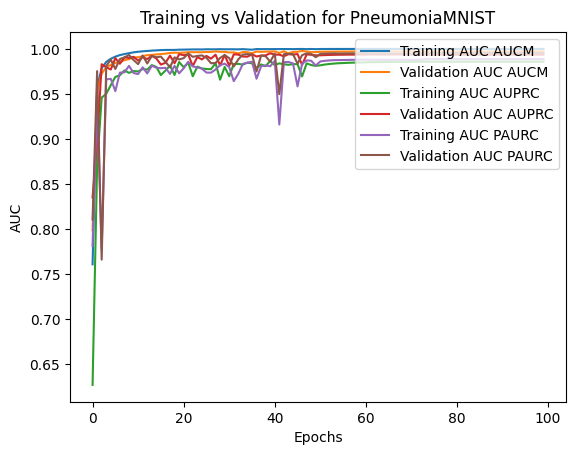

In [42]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for PneumoniaMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

# Chest MNIST

In [141]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['chestmnist']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Class Distribution: Counter({0: 1042052, 1: 56500})
Class 0: 94.86%
Class 1: 5.14%


In [76]:
# Chest MNIST
imratio_list = [0, 0, 0, 0, 0,
       0, 0, 0 , 0, 0,
       0, 0, 0, 0]
model = load_train_test_data('chestmnist', 5, imratio_list)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
AUC for train_eval is: 0.7653443827932273 and val AUC is: 0.7176473947978917 and best AUC is: 0.7182814862875139


In [77]:
# Evaluate on Test Set - With Data Aug
imratio_list = [0.1, 0, 0.1, 0.2, 0,
       0, 0, 0 , 0, 0,
       0, 0, 0, 0]
model = load_train_test_data('chestmnist', 5, imratio_list, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
AUC for train_eval is: 0.5496637385929793 and val AUC is: 0.5607202219103192 and best AUC is: 0.5954001262690866


In [78]:
# Evaluate on Test Set - No Data Aug
imratio_list = [0.1, 0, 0.1, 0.2, 0,
       0, 0, 0 , 0, 0,
       0, 0, 0, 0]
model, train_log, val_log = load_train_test_data('chestmnist', 5, imratio_list, 0, False, False, 0.001, 128, 0.9, 'pesg', 1e-3, 0.001, 0.001, 10)
print('==> Evaluating ...')
test(model, 'chestmnist', 256)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
AUC for train_eval is: 0.7568865366324502 and val AUC is: 0.712628693967992 and best AUC is: 0.712628693967992
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
AUC for test is: 0.7066092889302651 and PRC score is: 0.11175104935276432
test  auc: 0.7066092889302652  acc:0.7147792474097472


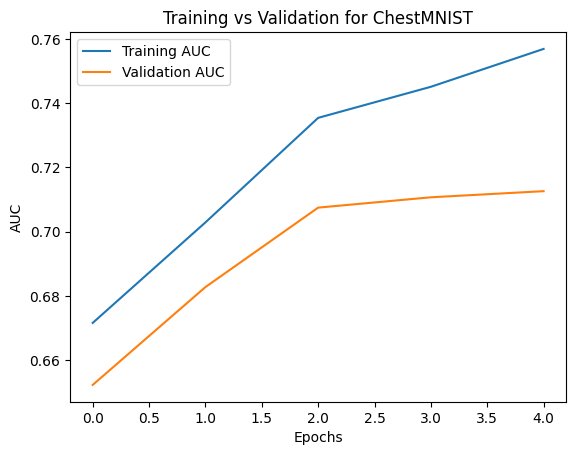

In [79]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(val_log, label='Validation AUC')
plt.title('Training vs Validation for ChestMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [147]:
# Save the model
torch.save(model.state_dict(), 'chest_mnist_model.pt')
# Load the model
from torchvision.models import resnet18
model =  resnet18(pretrained=False, num_classes=14)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('chest_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'chestmnist', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
AUC for test is: 0.7278451652570814 and PRC score is: 0.1353333998937726
test  auc: 0.7278451652570813  acc:0.8729391011965789


# Nodule MNIST

In [ ]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['nodulemnist3d']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

100%|██████████| 29299364/29299364 [01:29<00:00, 326012.54it/s]


Class Distribution: Counter({0: 863, 1: 295})
Class 0: 74.53%
Class 1: 25.47%


In [43]:
# Nodule MNIST - Without Sampler, lr=0.1, batch=128
model = load_train_test_data('nodulemnist3d', 100, 0)

100%|██████████| 29299364/29299364 [01:27<00:00, 333018.83it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 1.0 and val AUC is: 0.8625629113433991 and best AUC is: 0.875725900116144


In [44]:
# Nodule MNIST - With Sampler - lr=0.1, batch=128 - with/without not so much effect - Let's go with sampling
model = load_train_test_data('nodulemnist3d', 100, 0.25)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.9988412514484357 and val AUC is: 0.8418505613627565 and best AUC is: 0.8433991482771971


In [45]:
# Nodule MNIST - With Sampler and Data Aug - lr=0.1, batch=128 - Data Aug working
model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.5558222204764617 and val AUC is: 0.49690282617111886 and best AUC is: 0.5950445218737902


In [ ]:
# Trying different batch sizes - lower batch sizes are doing good - lets go with 128
batch_sizes = [64, 128, 256]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, False, 0.1, batch_size)

==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.9942612486988628 and val AUC is: 0.4942592592592593 and best AUC is: 0.5157407407407407 and Mean AUC is: 0.4942592592592593
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.992466170434236 and val AUC is: 0.4481481481481482 and best AUC is: 0.5242592592592593 and Mean AUC is: 0.4481481481481482
==> Applying Batch Size: 256
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.991594163049669 and val AUC is: 0.44685185185185183 and best AUC is: 0.5768518518518518 and Mean AUC is: 0.44685185185185183


In [ ]:
# Control Overfitting - Adding weight decay - 1e-03 is better
weight_decays = [1e-2, 1e-3]
for weight_decay in weight_decays:
    print('==> Applying Weight Decay: ' + str(weight_decay))
    model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, False, 0.1, 128, 0.9, 'pesg', weight_decay)

==> Applying Weight Decay: 0.01
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.9998900170866312 and val AUC is: 0.4790740740740741 and best AUC is: 0.5211111111111112 and Mean AUC is: 0.4790740740740741
==> Applying Weight Decay: 0.001
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 1.0 and val AUC is: 0.49444444444444435 and best AUC is: 0.5259259259259259 and Mean AUC is: 0.49444444444444435


In [ ]:
# Control Overfitting - Adding epoch decay - 0.1 is better
epoch_decays = [0.1, 0.01]
for epoch_decay in epoch_decays:
    print('==> Applying Epoch Decay: ' + str(epoch_decay))
    model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-03, epoch_decay)

==> Applying Epoch Decay: 0.1
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.9160987489443605 and val AUC is: 0.5018518518518519 and best AUC is: 0.535 and Mean AUC is: 0.5018518518518519
==> Applying Epoch Decay: 0.01
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for train_eval is: 0.9690633776538288 and val AUC is: 0.4651851851851852 and best AUC is: 0.5772222222222222 and Mean AUC is: 0.4651851851851852


In [ ]:
# Trying different learning and decay rates - lr starts high and then gradually decreasing it for every 25 epochs - 0.1 with 100 is better
learning_rates = [0.1, 0.01] 
decay_rates = [10, 100]
for learning_rate in learning_rates:
    for decay_rate in decay_rates:
        print('==> Applying Learning Rate: ' + str(learning_rate) + ' with decay: ' + str(decay_rate))
        model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, False, learning_rate, 128, 0.9, 'pesg', 1e-3, 1e-1, decay_rate)

==> Applying Learning Rate: 0.1 with decay: 10
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Reducing learning rate to 0.01000 @ T=1300!
Updating regularizer @ T=1300!
Reducing learning rate to 0.00100 @ T=1950!
Updating regularizer @ T=1950!
AUC for train_eval is: 0.9824302295893318 and val AUC is: 0.46296296296296297 and best AUC is: 0.517037037037037 and Mean AUC is: 0.46296296296296297
==> Applying Learning Rate: 0.1 with decay: 100
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Reducing learning rate to 0.00100 @ T=1300!
Updating regularizer @ T=1300!
Reducing learning rate to 0.00001 @ T=1950!
Updating regularizer @ T=1950!
AUC for train_eval is: 0.9327454484749689 and val AUC is: 0.48944444444444446 and best AUC is: 0.524074074074074 and Mean AUC is: 0.48944444444444446
==> Applying Learning Rat

In [ ]:
# Early Stopping - Not working
model = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, True, 0.1, 128, 0.9, 'pesg', 1e-3, 1e-1, 100)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Reducing learning rate to 0.00100 @ T=1300!
Updating regularizer @ T=1300!
Reducing learning rate to 0.00001 @ T=1950!
Updating regularizer @ T=1950!
Validation loss stopped improving. Early stopping at epoch 91
AUC for train_eval is: 0.9281654457253963 and val AUC is: 0.4575925925925926 and best AUC is: 0.5116666666666667 and Mean AUC is: 0.4575925925925926


In [46]:
# Evaluate on Test Set - AUROC
model, train_log, val_log = load_train_test_data('nodulemnist3d', 100, 0.25, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test(model, 'nodulemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Reducing learning rate to 0.00100 @ T=1300!
Updating regularizer @ T=1300!
Reducing learning rate to 0.00001 @ T=1950!
Updating regularizer @ T=1950!
AUC for train_eval is: 0.5483198146002317 and val AUC is: 0.5578784359272164 and best AUC is: 0.7220286488579172
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for test is: 0.5371570121951219 and PRC score is: 0.8097528342289377
test  auc: 0.46284298780487804  acc:0.7935483870967742


In [ ]:
# Save the model
torch.save(model.state_dict(), 'nodule_mnist_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('nodule_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'nodulemnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for test is: 0.9111407520325203 and best AUC is: 0.9111407520325203 and PRC score is: 0.9728603278612051


In [47]:
# Evaluate on Test Set - AUPRC Loss
model, train_log_prc, val_log_prc = load_train_test_data_prc('nodulemnist3d', 100, 0.25, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'nodulemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Reducing learning rate to 0.00100 @ T=1300!
Reducing learning rate to 0.00001 @ T=1950!
AUC for train_eval is: 0.9208748192406802 and val AUC is: 0.8378655458884066 and best AUC is: 0.838808256574425
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for test is: 0.9401661933237075 and Partial AUC is: 0.7996622429459589
test  auc: 0.15002540650406504  acc:0.267741935483871


In [ ]:
# Save the model
torch.save(model.state_dict(), 'nodule_mnist_prc_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('nodule_mnist_prc_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test_prc(model, 'nodulemnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for test is: 0.9482103522389413 and best AUC is: 0.9482103522389413


In [48]:
# Evaluate on Test Set - PAURC
model, train_log_paurc, val_log_paurc = load_train_test_data_paurc('nodulemnist3d', 100, 0.25, 0, False, 0.1, 128, 0.9, '', 1e-3, 1e-1, 100)
# Save the model
torch.save(model.state_dict(), 'nodule_mnist_paurc_model.pt')
print('==> Evaluating ...')
test_prc(model, 'nodulemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Backend loss: SOPA
Reducing lr to 0.00100 @ T=1300!
Reducing lr to 0.00001 @ T=1950!
AUC for train_eval is: 0.9242827716156283 and val AUC is: 0.9242827716156283 and best AUC is: 0.9248527110826654
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
AUC for test is: 0.9567906547983247 and Partial AUC is: 0.8171229874063446
test  auc: 0.1252540650406504  acc:0.7935483870967742


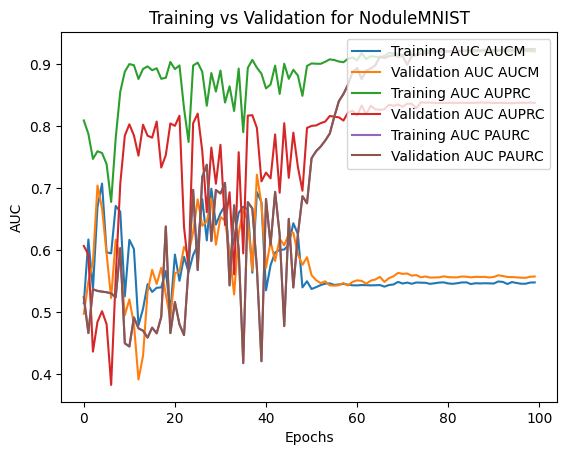

In [49]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for NoduleMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

# Adrenal MNIST

In [ ]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['adrenalmnist3d']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

100%|██████████| 276833/276833 [00:01<00:00, 275898.80it/s]

Class Distribution: Counter({0: 929, 1: 259})
Class 0: 78.20%
Class 1: 21.80%


In [50]:
# Adrenal MNIST - Without Sampler, lr=0.1, batch=128
model = load_train_test_data('adrenalmnist3d', 100, 0)

100%|██████████| 276833/276833 [00:00<00:00, 471332.99it/s]


Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9983666582159586 and val AUC is: 0.833133971291866 and best AUC is: 0.8355263157894737


In [51]:
# Adrenal MNIST - With Sampler - lr=0.1, batch=128 - with/without not so much effect - Let's go with sampling
model = load_train_test_data('adrenalmnist3d', 100, 0.2)

Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 1.0 and val AUC is: 0.8032296650717703 and best AUC is: 0.8104066985645934


In [ ]:
# Adrenal MNIST - With Sampler and Data Aug - lr=0.1, batch=128 - Data Aug working
model = load_train_test_data('adrenalmnist3d', 100, 0.2, 0, True)

Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9932588285656101 and val AUC is: 0.5261752136752137 and best AUC is: 0.6655982905982906 and Mean AUC is: 0.5261752136752137


In [ ]:
# Trying different batch sizes - lower batch sizes are doing good - lets go with 128
batch_sizes = [64, 128, 256]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('adrenalmnist3d', 100, 0.2, 0, True, False, 0.1, batch_size)

==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9940817335865774 and val AUC is: 0.5272435897435898 and best AUC is: 0.6233974358974359 and Mean AUC is: 0.5272435897435898
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9929762147200251 and val AUC is: 0.516025641025641 and best AUC is: 0.6356837606837606 and Mean AUC is: 0.516025641025641
==> Applying Batch Size: 256
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9903121636167923 and val AUC is: 0.5341880341880342 and best AUC is: 0.5982905982905983 and Mean AUC is: 0.5341880341880342


In [ ]:
# Control Overfitting - Adding weight decay - 1e-03 is better
weight_decays = [1e-2, 1e-3]
for weight_decay in weight_decays:
    print('==> Applying Weight Decay: ' + str(weight_decay))
    model = load_train_test_data('adrenalmnist3d', 100, 0.2, 0, True, False, 0.1, 128, 0.9, 'pesg', weight_decay)

==> Applying Weight Decay: 0.01
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.8208373682001239 and val AUC is: 0.5518162393162394 and best AUC is: 0.670940170940171 and Mean AUC is: 0.5518162393162394
==> Applying Weight Decay: 0.001
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for train_eval is: 0.9913678094517706 and val AUC is: 0.4898504273504274 and best AUC is: 0.6639957264957265 and Mean AUC is: 0.4898504273504274


In [63]:
# Evaluate on Test Set -AUROC
model, train_log, val_log = load_train_test_data('adrenalmnist3d', 100, 0.2, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test(model, 'adrenalmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Reducing learning rate to 0.00100 @ T=1850!
Updating regularizer @ T=1850!
Reducing learning rate to 0.00001 @ T=2775!
Updating regularizer @ T=2775!
AUC for train_eval is: 0.9071405712955767 and val AUC is: 0.8223684210526315 and best AUC is: 0.8450956937799043
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for test is: 0.8303271944813618 and PRC score is: 0.9378746475160467
test  auc: 0.16967280551863806  acc:0.40939597315436244


In [ ]:
# Save the model
torch.save(model.state_dict(), 'adrenal_mnist_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('adrenal_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'adrenalmnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for test is: 0.8665907221061959 and best AUC is: 0.8665907221061959 and PRC score is: 0.9580298187113887


In [53]:
# Evaluate on Test Set - AUPRC Loss
model, train_log_prc, val_log_prc = load_train_test_data_prc('adrenalmnist3d', 100, 0.2, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'adrenalmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Reducing learning rate to 0.00100 @ T=1850!
Reducing learning rate to 0.00001 @ T=2775!
AUC for train_eval is: 0.9375278697704859 and val AUC is: 0.838606713741267 and best AUC is: 0.838606713741267
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for test is: 0.9502212834750531 and Partial AUC is: 0.7859281678622971
test  auc: 0.1487880513891526  acc:0.3187919463087248


In [ ]:
# Save the model
torch.save(model.state_dict(), 'adrenal_mnist_prc_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('adrenal_mnist_prc_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test_prc(model, 'adrenalmnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for test is: 0.9404990524475865 and best AUC is: 0.9404990524475865


In [54]:
# Evaluate on Test Set - PAURC Loss
model, train_log_paurc, val_log_paurc = load_train_test_data_paurc('adrenalmnist3d', 100, 0.2, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'adrenalmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
Backend loss: SOPA
Reducing lr to 0.00100 @ T=1850!
Reducing lr to 0.00001 @ T=2775!
AUC for train_eval is: 0.6923282157246572 and val AUC is: 0.6923282157246572 and best AUC is: 0.6934348754775526
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/adrenalmnist3d.npz
AUC for test is: 0.9336644476174222 and Partial AUC is: 0.7540115976774862
test  auc: 0.19600025314853486  acc:0.7684563758389261


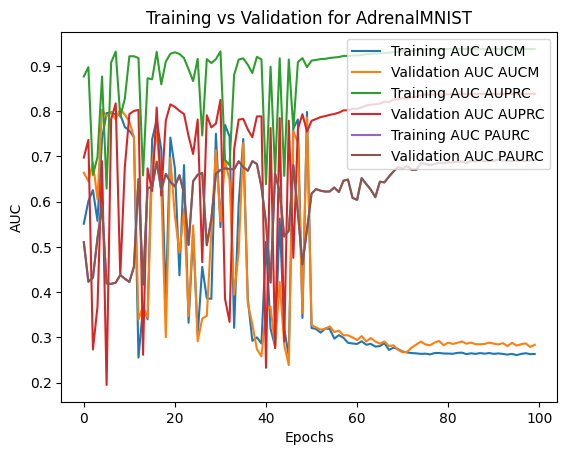

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for AdrenalMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

# Vessel MNIST

In [ ]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['vesselmnist3d']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

100%|██████████| 398373/398373 [00:00<00:00, 473655.10it/s]


Class Distribution: Counter({0: 1185, 1: 150})
Class 1: 11.24%
Class 0: 88.76%


In [56]:
# Vessel MNIST
model = load_train_test_data('vesselmnist3d')

100%|██████████| 398373/398373 [00:01<00:00, 295029.23it/s]


Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for train_eval is: 1.0 and val AUC is: 0.8839572192513369 and best AUC is: 0.893048128342246


In [57]:
# Evaluate on Test Set - No Data Aug
model = load_train_test_data('vesselmnist3d', 100, 0.1, 0, False, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test(model, 'vesselmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Reducing learning rate to 0.00100 @ T=4900!
Updating regularizer @ T=4900!
Reducing learning rate to 0.00001 @ T=7350!
Updating regularizer @ T=7350!
AUC for train_eval is: 0.9993980309423348 and val AUC is: 0.7486631016042781 and best AUC is: 0.8574866310160427
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz


AttributeError: ignored

In [58]:
# Evaluate on Test Set - AUROC
model, train_log, val_log = load_train_test_data('vesselmnist3d', 100, 0.1, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test(model, 'vesselmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Reducing learning rate to 0.00100 @ T=4900!
Updating regularizer @ T=4900!
Reducing learning rate to 0.00001 @ T=7350!
Updating regularizer @ T=7350!
AUC for train_eval is: 0.733929676511955 and val AUC is: 0.7264705882352941 and best AUC is: 0.8237967914438504
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for test is: 0.7195582081361047 and PRC score is: 0.9558426590609632
test  auc: 0.2804417918638952  acc:0.5654450261780105


In [ ]:
# Save the model
torch.save(model.state_dict(), 'vessel_mnist_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('vessel_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'vesselmnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for test is: 0.8372779035466831 and best AUC is: 0.8372779035466831 and PRC score is: 0.9777192061749826


In [59]:
# Evaluate on Test Set - AUPRC Loss
model, train_log_prc, val_log_prc = load_train_test_data_prc('vesselmnist3d', 100, 0.1, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'vesselmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Reducing learning rate to 0.00100 @ T=4900!
Reducing learning rate to 0.00001 @ T=7350!
AUC for train_eval is: 0.9900491081386167 and val AUC is: 0.9175021097046412 and best AUC is: 0.9395724331926862
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for test is: 0.9796871002276818 and Partial AUC is: 0.835935471808261
test  auc: 0.14955066200178363  acc:0.21204188481675393


In [ ]:
# Save the model
torch.save(model.state_dict(), 'vessel_mnist_prc_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('vessel_mnist_prc_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test_prc(model, 'vesselmnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for test is: 0.9751638697864619 and best AUC is: 0.9751638697864619


In [60]:
# Evaluate on Test Set - PAURC Loss
model, train_log_paurc, val_log_paurc = load_train_test_data_paurc('vesselmnist3d', 100, 0.1, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'vesselmnist3d', 256)

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Backend loss: SOPA
Reducing lr to 0.00100 @ T=4900!
Reducing lr to 0.00001 @ T=7350!
AUC for train_eval is: 0.7133007914839635 and val AUC is: 0.7133007914839635 and best AUC is: 0.7650368164143295
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
AUC for test is: 0.958949038406735 and Partial AUC is: 0.6975762246999369
test  auc: 0.2691911916032106  acc:0.887434554973822


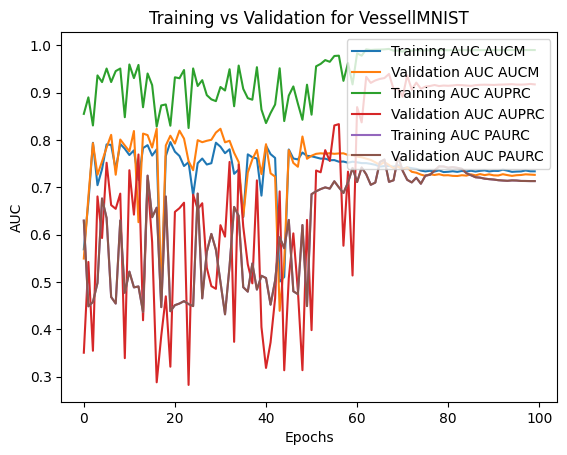

In [61]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for VessellMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

# Synapse MNIST

In [24]:
import medmnist
from collections import Counter

# Load the breast dataset
DataClass = getattr(medmnist, INFO['synapsemnist3d']['python_class'])
breast = DataClass(split='train', download=True)

# Get the labels of all the samples
labels = [label for _, label in breast]

# Count the number of samples in each class
labels = np.array(labels).flatten()
class_count = Counter(labels)

# Print the class distribution
print('Class Distribution:', class_count)

# Calculate the percentage of samples in each class
total_samples = len(labels)
for label, count in class_count.items():
    percentage = count / total_samples * 100
    print('Class {}: {:.2f}%'.format(label, percentage))

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Class Distribution: Counter({1: 899, 0: 331})
Class 1: 73.09%
Class 0: 26.91%


In [64]:
# Synapse MNIST - Without Sampler, lr=0.1, batch=128
model = load_train_test_data('synapsemnist3d', 100, 0)

100%|██████████| 38034583/38034583 [00:54<00:00, 700450.58it/s] 


Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.6877698953856082 and val AUC is: 0.46285529715762275 and best AUC is: 0.5725129198966407


In [65]:
# Synapse MNIST - With Sampler - lr=0.1, batch=128 - with/without not so much effect - Let's go with sampling
model = load_train_test_data('synapsemnist3d', 100, 0.27)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 1.0 and val AUC is: 0.5923772609819121 and best AUC is: 0.5977067183462532


In [27]:
# Synapse MNIST - With Sampler and Data Aug - lr=0.1, batch=128 - Data Aug working
model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.4836945380735224 and val AUC is: 0.0 and best AUC is: 0


In [ ]:
# Trying different batch sizes - lower batch sizes are doing good - lets go with 64
batch_sizes = [64, 128, 256]
for batch_size in batch_sizes:
    print('==> Applying Batch Size: ' + str(batch_size))
    model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True, False, 0.1, batch_size)

==> Applying Batch Size: 64
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9636521277418011 and val AUC is: 0.9636521277418011 and best AUC is: 0.9701144944533873
==> Applying Batch Size: 128
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9569713242978939 and val AUC is: 0.9569713242978939 and best AUC is: 0.9569713242978939
==> Applying Batch Size: 256
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9169167487204648 and val AUC is: 0.9169167487204648 and best AUC is: 0.9169167487204648


In [ ]:
# Trying different Optimizers - PESG works
optimizers = ['sgd', 'adam', 'rmsprop', 'pesg']
for optimizer in optimizers:
    print('==> Applying Optimizer: ' + str(optimizer))
    model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True, False, 0.1, 64, 0.9, optimizer)

==> Applying Optimizer: sgd
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.41074507089112106 and val AUC is: 0.41074507089112106 and best AUC is: 0.5213715138337663
==> Applying Optimizer: adam
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.45265131784560897 and val AUC is: 0.45265131784560897 and best AUC is: 0.4557195137934395
==> Applying Optimizer: rmsprop
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.52386841371245 and val AUC is: 0.52386841371245 and best AUC is: 0.5272155365646287
==> Applying Optimizer: pesg
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.med

In [7]:
# Control Overfitting - Adding weight decay - 1e-03 is better
weight_decays = [0.1, 1e-2, 1e-3, 1e-5, 1e-7]
for weight_decay in weight_decays:
    print('==> Applying Weight Decay: ' + str(weight_decay))
    model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True, False, 0.1, 64, 0.9, 'pesg', weight_decay)

==> Applying Weight Decay: 0.1


100%|██████████| 38034583/38034583 [00:06<00:00, 5535708.59it/s]


Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.5 and val AUC is: 0.5 and best AUC is: 0.7717705809408909
==> Applying Weight Decay: 0.01
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9251971811579834 and val AUC is: 0.9251971811579834 and best AUC is: 0.978485662148947
==> Applying Weight Decay: 0.001
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9838155184175771 and val AUC is: 0.9838155184175771 and best AUC is: 0.9853412149787107
==> Applying Weight Decay: 1e-05
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9782033746794861 and val AUC is: 0.9782033746794861 and best AUC is: 0.9

In [8]:
# Control Overfitting - Adding epoch decay - 0.1 is better
epoch_decays = [0.1, 0.01, 1e-3, 1e-5]
for epoch_decay in epoch_decays:
    print('==> Applying Epoch Decay: ' + str(epoch_decay))
    model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True, False, 0.1, 64, 0.9, 'pesg', 1e-03, epoch_decay)

==> Applying Epoch Decay: 0.1
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.6884285661476834 and val AUC is: 0.6884285661476834 and best AUC is: 0.7710850256579147
==> Applying Epoch Decay: 0.01
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for train_eval is: 0.9504081406329289 and val AUC is: 0.9504081406329289 and best AUC is: 0.9751553421223312


In [9]:
# Trying different learning and decay rates - lr starts high and then gradually decreasing it for every 25 epochs - 0.1 with 10 is better
learning_rates = [0.1, 0.01, 0.001] 
decay_rates = [10, 100]
for learning_rate in learning_rates:
    for decay_rate in decay_rates:
        print('==> Applying Learning Rate: ' + str(learning_rate) + ' with decay: ' + str(decay_rate))
        model = load_train_test_data('synapsemnist3d', 100, 0.27, 0, True, False, learning_rate, 64, 0.9, 'pesg', 1e-3, 0, decay_rate)

==> Applying Learning Rate: 0.1 with decay: 10
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Reducing learning rate to 0.01000 @ T=950!
Updating regularizer @ T=950!
Reducing learning rate to 0.00100 @ T=1425!
Updating regularizer @ T=1425!
AUC for train_eval is: 0.9708571793432783 and val AUC is: 0.9708571793432783 and best AUC is: 0.9708571793432783
==> Applying Learning Rate: 0.1 with decay: 100
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Reducing learning rate to 0.00100 @ T=950!
Updating regularizer @ T=950!
Reducing learning rate to 0.00001 @ T=1425!
Updating regularizer @ T=1425!
AUC for train_eval is: 0.9454042591802236 and val AUC is: 0.9454042591802236 and best AUC is: 0.9461939919816915
==> Applying Learning Rate: 0.01 with decay: 10
Using downloaded and verified file: /root/.medmnist

In [ ]:
# Evaluate on Test Set - No Data Aug
model = load_train_test_data('synapsemnist3d', 100, 0.25, 0, False, False, 0.1, 128, 0.9, 'pesg', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test(model, 'synapsemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Reducing learning rate to 0.00100 @ T=500!
Updating regularizer @ T=500!
Reducing learning rate to 0.00001 @ T=750!
Updating regularizer @ T=750!
AUC for train_eval is: 1.0 and val AUC is: 1.0 and best AUC is: 1.0
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for test is: 0.5970919516690559 and best AUC is: 0.5970919516690559


In [66]:
# Evaluate on Test Set - With AUROC
model, train_log, val_log = load_train_test_data('synapsemnist3d', 100, 0.25, 0, True, False, 0.1, 128, 0.9, 'pesg', 1e-03, 0.1, 100)
print('==> Evaluating ...')
test(model, 'synapsemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Reducing learning rate to 0.00100 @ T=500!
Updating regularizer @ T=500!
Reducing learning rate to 0.00001 @ T=750!
Updating regularizer @ T=750!
AUC for train_eval is: 0.8216447277774229 and val AUC is: 0.6950904392764857 and best AUC is: 0.7230297157622738
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for test is: 0.720499692811796 and PRC score is: 0.46341996196910307
test  auc: 0.27950030718820396  acc:0.26988636363636365


In [67]:
# Evaluate on Test Set - AUPRC Loss
model, train_log_prc, val_log_prc = load_train_test_data_prc('synapsemnist3d', 100, 0.25, 0, True, 0.1, 128, 0.9, '', 1e-3, 0.1, 100)
print('==> Evaluating ...')
test_prc(model, 'synapsemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Reducing learning rate to 0.00100 @ T=500!
Reducing learning rate to 0.00001 @ T=750!
AUC for train_eval is: 0.4075100708251759 and val AUC is: 0.6471742688250456 and best AUC is: 0.6477455648941927
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for test is: 0.3616360886213982 and Partial AUC is: 0.5649251304044042
test  auc: 0.37063280770018425  acc:0.32670454545454547


In [68]:
# Evaluate on Test Set - PAUPRC Loss
model, train_log_paurc, val_log_paurc = load_train_test_data_paurc('synapsemnist3d', 100, 0.25, 0, True, 0.1, 128, 0.9, '', 1e-03, 0, 100)
print('==> Evaluating ...')
test_prc(model, 'synapsemnist3d', 256)

Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
Backend loss: SOPA
Reducing lr to 0.00100 @ T=500!
Reducing lr to 0.00001 @ T=750!
AUC for train_eval is: 0.5692651676305888 and val AUC is: 0.5692651676305888 and best AUC is: 0.5725275515271825
==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for test is: 0.4032979930422498 and Partial AUC is: 0.5677520649873712
test  auc: 0.3526315789473684  acc:0.7301136363636364


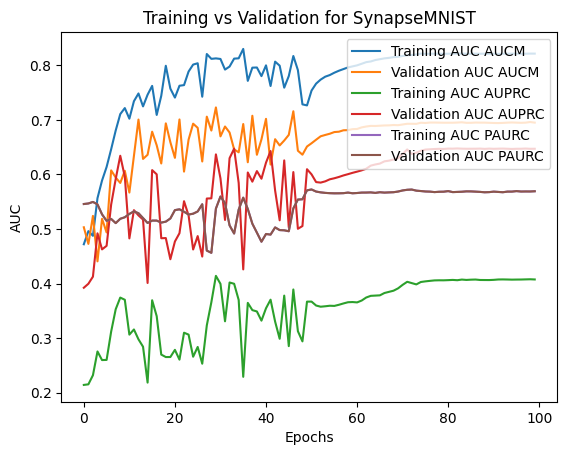

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC AUCM')
plt.plot(val_log, label='Validation AUC AUCM')
plt.plot(train_log_prc, label='Training AUC AUPRC')
plt.plot(val_log_prc, label='Validation AUC AUPRC')
plt.plot(train_log_paurc, label='Training AUC PAURC')
plt.plot(val_log_paurc, label='Validation AUC PAURC')
plt.title('Training vs Validation for SynapseMNIST')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'synapse_mnist_model.pt')
# Load the model
model = ResNet18(pretrained=False)
model.conv1 = nn.Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('synapse_mnist_model.pt'))
model = model.cuda()
print('==> Evaluating ...')
test(model, 'synapsemnist3d', 256)

==> Evaluating ...
Using downloaded and verified file: /root/.medmnist/synapsemnist3d.npz
AUC for test is: 0.7776366987507679 and best AUC is: 0.7776366987507679 and PRC score is: 0.5346649090852572
